In [205]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [206]:
def preprocessing(words):
    unwanted_chars = ['ß', 'à', 'ä', 'ç', 'è', 'é', 'ï', 'ñ', 'ó', 'ö', 'ü', 'ā']

    def contains_unwanted_chars(word):
        return any(char in unwanted_chars for char in word)

    words = [haiku for haiku in words if not any(contains_unwanted_chars(word) for word in haiku)]
    return words

def load_data(path):
    with open(path, 'r') as f:
        words = f.read().splitlines()
    words = preprocessing(words)
    return words

words = load_data('lines.txt')
words = [wr.replace("/", "").replace("$", "") for wr in words]
chars = sorted(list(set(''.join(words)))) #+ ["<S>", "<M>", "<E>"]
stoi = {ch: i for i, ch in enumerate(chars)}
itos = {i: ch for ch, i in stoi.items()}

In [207]:
def build_dataset(words):
    block_size = 10
    X, Y = [], []
    for w in words:
        context = [3] * block_size
        #print(w)
        # w = w.split("  ")
        # chs = ["<S>"] + list(w[0]) + ["<M>"] + list(w[1])+ ["<M>"] + list(w[2]) + ["<E>"]
        for ch in w + ".": #chs:
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            #print(f"'{''.join(itos[i] for i in context)}'", '---->', itos[ix])

            context = context[1:] + [ix]
    
    X, Y = torch.tensor(X), torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y


import random
random.seed(43)

n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))

Xtrain, Ytrain = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xtest, Ytest = build_dataset(words[n2:])

torch.Size([637487, 10]) torch.Size([637487])
torch.Size([79514, 10]) torch.Size([79514])
torch.Size([79753, 10]) torch.Size([79753])


In [208]:
g = torch.Generator().manual_seed(213139812739)

In [209]:
from typing import List
import numpy as np

class Layer():
    def __init__(self, fan_in, fan_out, kaiming=False, activation=F.tanh):
        self.W = torch.randn((fan_in, fan_out), generator=g) * 5/3 / (fan_in ** 0.5)  if kaiming else torch.randn((fan_in, fan_out), generator=g)
        self.b = torch.randn(fan_out, generator=g) * 0

        self.params = [self.W, self.b]
        self.activation_fn = activation

        for param in self.params:
            param.requires_grad = True
    
    def activation(self, x):
        return self.activation_fn(x)
        
    def _f(self, x):
        out = x @ self.W + self.b
        return self.activation(out) if self.activation_fn else out
    
class BatchNorm():
    def __init__(self, fan_in, eps):
        self.bngain = torch.ones((1, fan_in))
        self.bnbias = torch.zeros((1, fan_in))

        self.bnmean_running = torch.zeros((1, fan_in))
        self.bnstd_running = torch.ones((1, fan_in))

        self.params = [self.bngain, self.bnbias]

        self.eps = eps

        for param in self.params:
            param.requires_grad = True

    def _f(self, x, train=True):
        mean = x.mean(0, keepdim=True)
        std = x.std(0, keepdim=True)

        if train:
            x = (x - mean) / (std + self.eps)
            x = x * self.bngain + self.bnbias
            with torch.no_grad():
                self.bnmean_running = 0.999 * self.bnmean_running + 0.001 * mean
                self.bnstd_running = 0.999 * self.bnstd_running + 0.001 * std
        else:
            x = (x - self.bnmean_running) / (self.bnstd_running + self.eps)
            x = x * self.bngain + self.bnbias

        return x

class Sequential():
    def __init__(self, layers: List[Layer]):
        self.layers = layers
        self.params = []
        for layer in self.layers:
            self.params.extend(layer.params)
    
    def forward(self, x, y, lr):
        out = x
        for layer in self.layers:
            out = layer._f(out)
        
        loss = F.cross_entropy(out, y)

        for p in self.params:
            p.grad = None
        
        loss.backward()

        for p in self.params:
            p.data += -lr * p.grad

        return loss

    def predict(self, x):
        with torch.no_grad():
            out = x
            for layer in self.layers:
                if isinstance(layer, BatchNorm):
                    out = layer._f(out, train=False)
                else:
                    out = layer._f(out)
        return out
    
    def display_layer_sizes(self):
        print("Layer Sizes (Top to Bottom):")
        for idx, layer in enumerate(self.layers):
            if isinstance(layer, Layer):
                print(f"Layer {idx + 1}: Input Size = {layer.W.shape[0]}, Output Size = {layer.W.shape[1]}")
            elif isinstance(layer, BatchNorm):
                print(f"Layer {idx + 1}: BatchNorm with Input Size = {layer.bngain.shape[1]}")
            else:
                print(f"Layer {idx + 1}: Unknown Layer Type")

In [211]:
n_embd = 20
block_size = 10
neurons = [128, 64, 32]
embeddings = torch.randn(len(chars), n_embd, generator=g)

layers = [
    Layer(n_embd * block_size, neurons[0], kaiming=True, activation=F.tanh), 
    BatchNorm(neurons[0], 1e-5),
    Layer(neurons[0], neurons[1], kaiming=True, activation=F.tanh), 
    BatchNorm(neurons[1], 1e-5),
    Layer(neurons[1], neurons[2], kaiming=True, activation=F.tanh), 
    BatchNorm(neurons[2], 1e-5),
    Layer(neurons[2], len(chars), activation=None)
]

model = Sequential(layers)

In [212]:
model.display_layer_sizes()

Layer Sizes (Top to Bottom):
Layer 1: Input Size = 200, Output Size = 128
Layer 2: BatchNorm with Input Size = 128
Layer 3: Input Size = 128, Output Size = 64
Layer 4: BatchNorm with Input Size = 64
Layer 5: Input Size = 64, Output Size = 32
Layer 6: BatchNorm with Input Size = 32
Layer 7: Input Size = 32, Output Size = 30


In [213]:
def train_model(
    model: Sequential, 
    num_epochs: int, 
    lr: float = 0.01, 
    verbose: bool = True,
    batch_size: int = 128,
    lr_slow_reduce: bool = False
) -> List[float]:
    losses = []

    for epoch in range(num_epochs):
        if lr_slow_reduce and num_epochs // 2 == epoch:
            lr *= 1e-1
        ix = torch.randint(0, Xtrain.shape[0], (batch_size,), generator=g)
        Xb, Yb = Xtrain[ix], Ytrain[ix]
        emb = embeddings[Xb]
        emb = emb.view(emb.shape[0], -1)
        loss = model.forward(emb, Yb, lr)
        losses.append(loss.item())

        if verbose and (epoch + 1) % 1000 == 0:
            print(f"Epoch {epoch + 1}/{num_epochs} Loss: {loss.item()}")

    return losses

losses = train_model(model, 50000, lr=0.1, lr_slow_reduce=True)  

Epoch 1000/50000 Loss: 2.422591209411621
Epoch 2000/50000 Loss: 2.2670445442199707
Epoch 3000/50000 Loss: 2.176182508468628
Epoch 4000/50000 Loss: 2.049243927001953
Epoch 5000/50000 Loss: 2.118278980255127
Epoch 6000/50000 Loss: 2.0675911903381348
Epoch 7000/50000 Loss: 1.9457987546920776
Epoch 8000/50000 Loss: 2.040745258331299
Epoch 9000/50000 Loss: 1.7945162057876587
Epoch 10000/50000 Loss: 2.057861089706421
Epoch 11000/50000 Loss: 1.944896936416626
Epoch 12000/50000 Loss: 1.7303568124771118
Epoch 13000/50000 Loss: 1.8907662630081177
Epoch 14000/50000 Loss: 1.7142219543457031
Epoch 15000/50000 Loss: 1.821274995803833
Epoch 16000/50000 Loss: 2.0262625217437744
Epoch 17000/50000 Loss: 2.1310830116271973
Epoch 18000/50000 Loss: 1.794228196144104
Epoch 19000/50000 Loss: 1.8933732509613037
Epoch 20000/50000 Loss: 1.7529749870300293
Epoch 21000/50000 Loss: 1.832837462425232
Epoch 22000/50000 Loss: 1.6195073127746582
Epoch 23000/50000 Loss: 1.8125598430633545
Epoch 24000/50000 Loss: 1.9074

Text(0.5, 0, 'Epoch')

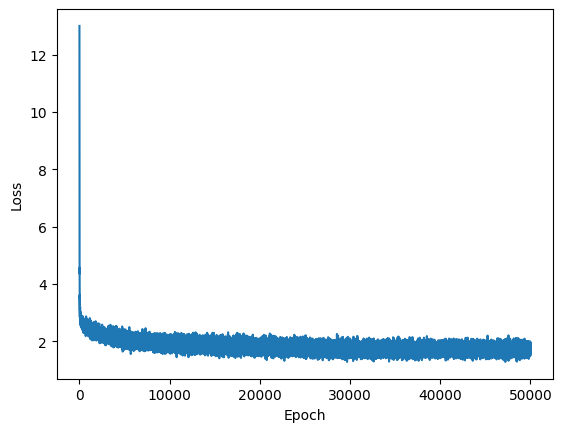

In [214]:
plt.plot(np.arange(len(losses)), losses)
plt.ylabel("Loss")
plt.xlabel("Epoch")

In [215]:
@torch.no_grad()
def split_loss(split):
    x,y = {
        'train': (Xtrain, Ytrain),
        'dev': (Xdev, Ydev),
        'test': (Xtest, Ytest)
    }[split]
    emb = embeddings[x]
    emb = emb.view(emb.shape[0], -1)
    out = model.predict(emb)   
    loss = F.cross_entropy(out, y)

    return loss.item()

In [216]:
split_loss('train'), split_loss('dev'), split_loss('test')

(1.6678565740585327, 1.7043620347976685, 1.721247911453247)

### Improvement!!

### Pre weight init optimization -> (1.7559022903442383, 1.7703694105148315, 1.785829782485962)
### Post weight init optimization -> (1.7148950099945068, 1.729537844657898, 1.7452518939971924)
### Post Batch norm -> (1.77047860622406, 1.7761619091033936, 1.7911485433578491)
### Multiple layers with batch norm -> (1.6678565740585327, 1.7043620347976685, 1.721247911453247) - > BEST RESULT YET!


#### Is this proof that batch norm sucks with lesser layers?

In [227]:
def complete_word(model, start_chars, block_size=10):
    context = [10] * (block_size - len(start_chars))
    context.extend([stoi[ch] for ch in start_chars])
    
    res = list(start_chars)
    
    while True:
        emb = embeddings[torch.tensor(context)]
        emb = emb.view(1, -1)
        out = model.predict(emb)
        
        out = F.softmax(out, dim=-1)
        out = torch.multinomial(out, 1).item()
        
        if out == 3:
            break
            
        res.append(itos[out])
        context = context[1:] + [out]
    
    return ''.join(res)

prompts = [
    "dream",
    "star",
    "moon",
    "whisper",
    "ember",
    "mist",
    "azure",
    "shadow",
    "crystal",
    "velvet",
    "river",
    "sunset",
    "autumn",
    "silver",
    "echo"
]

for word in prompts:
    print(f"{complete_word(model, word).replace('  ', ' ').replace('   ', ' ')}")

dreams my below roting show golding as over theavy the wind just on black with the sured was in you harm wame serplas 
stars is was for dill ball somethtippart  bavus day  years 
moon it 
whisper of somer return 
embers dark like for getbreaded 
mist forgsenbling detil will the call west here une in a dog my prote like  when is it to hard beauty 
azure of your rose twill do a gleps the rice this world i prows sharchick love i confight 
shadow look heruless her  an smile rewell do gives 
crystal 
velvet toger guing buant all touch pill all i reedlesidenfing to eyervess cait scares 
river will plomes 
sunset tarkens agargnkes soghat and heart yeg i wants forever at for maks face i still my rockit 
autumns noinallect my moth wish irabin uwh deets when i culrow i'd you oll led bag through to flor a stay on the lepity fafts are if beeinning pather devit bessed  i will wanches me worls happiness beese 
silver it on my luckies apy little life the buened he place i'm the in need kindin 
echols

/var/folders/np/gp8d_33j4jxd2pd79hf5w03r0000gn/T/ipykernel_7467/1895009486.py:39: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/ReduceOps.cpp:1823.)
  std = x.std(0, keepdim=True)
